Student: Dorin Doncenco

Todo: Learn MCTSA maybe read some youtube vids

# TP 3 - Planning (November 30)


![ChessUrl](https://gymnasium.farama.org/_images/frozen_lake.gif "Frozen Lake")

In this assignement, we focus on algorithms that require a **model** of the environment behavior. You will implement :

- A Monte Carlo Tree Search Algorithm
- A Tabular Dyna-Q Algorithm

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A Paragraph of analysis of the behavior of the algorithms . 

Send this notebook  to cyriaque.rousselot@inria.fr before next course.


In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

## Environment

### Snapshots

For the sake of planning algorithm, we will introduce the possibility of taking snapshots of the environment. Snapshots allows to return to a previously visited state.

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import time
# library to clear output
from IPython.display import clear_output

In [3]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200))
env.reset()
n_actions = env.action_space.n
n_states = env.observation_space.n

In [4]:
import matplotlib.pyplot as plt
print("initial_state:")
print(env.render())
# plt.axis('off')
env.close()

# create first snapshot
snap0 = env.get_snapshot()

initial_state:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [5]:
while True:
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break

print("final state:")
print(env.render())
env.close()

Whoops! We died!
final state:
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [6]:
# reload initial state
env.load_snapshot(snap0)

print("After loading snapshot")
print(env.render())
env.close()

After loading snapshot

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



## Monte Carlo Tree Search

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search ; Sutton-Barto Chapter 8.11

The MCTS algorithm we will implement can be divided in 4 steps:
- Selection 
- Expansion
- Simulation
- Backpropagation

The first step is exploring the current tree using a UCB-1 rule until we get to a leaf L .

The second is creating a child C from feasable moves after the leaf L if the game is not finished.

The third is simulating the end of the game with an unbiased method to get an estimate of the value of the position C.

The fourth is updating the value estimation of the position of all nodes visited during the exploration of the tree.



![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

We will use snapshots to simulate the effect of a sample model:
1. Saving a snapshot of state S
2. sending S,A to the environement
3. Getting back R and S'
4. When needed, loading the snapshot of state S

## Building the agent:

> Fill the blanks in the code

In [7]:
class Node:
    """A node in the Monte Carlo Tree Search (MCTS) algorithm."""
    
    #metadata:
    parent = None          #parent Node
    qvalue_sum = 0.         #sum of state values from all visits (numerator)
    times_visited = 0      #counter of visits (denominator)

    def __init__(self, parent, action):
        """
        Initializes a tree node with a parent, action, and environment.

        :param parent: parent TreeNode
        :param action: action to commit from parent Node
        """

        self.parent = parent
        self.action = action
        self.children = set()

        # Capture the outcome after performing the action in the parent's state
        result = env.get_result(parent.snapshot, action)
        (
            self.snapshot,
            self.observation,
            self.immediate_reward,
            self.is_done,
            _,
        ) = result


    def is_leaf(self):
        return not self.children

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        if self.times_visited !=0:
            return self.qvalue_sum / self.times_visited
        return 0

    def ucb_score(self, scale=2, max_value=float("inf")):
        """
        Computes the Upper Confidence Bound (UCB) score for the node.

        :param scale: Multiplies the upper bound by this value. Assumes reward range to be [0, scale].
        :param max_value: a value representing infinity (for unvisited nodes).
        """
        if self.times_visited == 0:
            return max_value

        return self.get_qvalue_estimate() + scale * np.sqrt(2*np.log(self.parent.times_visited) / self.times_visited)

    # MCTS steps

    def select_best_leaf(self):
        """
        Selects the leaf with the highest priority to expand.

        Recursively picks nodes with the best UCB score until it reaches a leaf.
        """
        # Using the UCB valuation, select the best possible child among children of a node
        if self.is_leaf():
            return self
        children = self.children
        
        # get the best child, or random if equal
        best_value = max([child.ucb_score() for child in children])
        best_children = [child for child in children if child.ucb_score() == best_value]
        best_child = np.random.choice(best_children)
        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        # Create a new child node and add it to the current node's children set
        for action in range(n_actions):
            # Check if the action is already in the children set
            for child in self.children:
                if child.action == action:
                    continue
            child = Node(self, action)
            self.children.add(child)
        return self.select_best_leaf()

    def rollout(self, t_max=10**1):
        """
        Plays the game from this state to the end (done) or for t_max steps.

        On each step, picks an action at random.

        Computes the sum of rewards from the current state until the end of the episode.

        If the node is terminal, return the immediate reward
        """

        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done
        rollout_reward = 0
        while not is_done and t_max>0:
            action = env.action_space.sample()
            # check env step return docs
            obs, reward, is_done, truncated, _ = env.step(action)
            rollout_reward += reward
            t_max -= 1
            


        return rollout_reward

    def propagate(self, child_qvalue):
        """
        Uses the child Q-value to update parents number of visits and qvalue recursively.
        """
        my_qvalue = self.immediate_reward + child_qvalue

        # Update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # Propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

            
    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child


In [8]:
class Root(Node):
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = set()
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        root = Root(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root


### Running the MCTS 

In [9]:
def plan_mcts(root, n_iters=10, t_max=10**1):
    """
    Builds a tree with Monte-Carlo Tree Search for n_iters iterations.
    :param root: Tree node to plan from.
    :param n_iters: Number of select-expand-simulate-propagate loops to make.
    """
    for _ in range(n_iters):
        node = root.select_best_leaf()

        if node.is_done:
            # All rollouts from a terminal node are empty, and thus have 0 reward.
            node.propagate(0)
        else:
            # Expand the best leaf, perform a rollout from it, and propagate the results upwards.
            node = node.expand()
            reward = node.rollout(t_max)
            node.propagate(reward)  

In [10]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="4x4",
                             render_mode="ansi",
                             max_episode_steps=200,
                             is_slippery=False))
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

> Use the MCTS implementation to find the optimal policy and show it. Bonus point will be given to a clear display

In [11]:
plan_mcts(root, n_iters=5000)

In [12]:
id_to_action = {
    None: "ORIGIN",
    0: " LEFT ",
    1: " DOWN ",
    2: "RIGHT ",
    3: "  UP  ",
}

In [13]:
# display tree
def display_tree(node, depth=0, max_depth=3):
    if depth > max_depth:
        return
    prefix = "  " * depth + "|%d|" %depth
    print(prefix, "Q = %.3f" %node.get_qvalue_estimate(), "A = ", id_to_action[node.action], "N =", node.times_visited)
    for child in node.children:
        display_tree(child, depth + 1, max_depth)

def display_tree_max_only(node, depth=0, max_depth=3):
    if depth > max_depth:
        return
    prefix = "  " * depth + "|%d|" %depth
    # find best child
    best_child = max(node.children, key=lambda child: child.get_qvalue_estimate())
    print(prefix, "Q = %.3f" %node.get_qvalue_estimate(), "A = ", id_to_action[node.action], "N =", node.times_visited)
    if not(best_child.is_leaf()):
        display_tree_max_only(best_child, depth + 1, max_depth)

def display_tree_non_zeros(node, depth=0, max_depth=3):
    if depth > max_depth:
        return
    prefix = "  " * depth + "|%d|" %depth
    if node.get_qvalue_estimate() != 0:
        print(prefix, "Q = %.3f" %node.get_qvalue_estimate(), "A = ", id_to_action[node.action], "N =", node.times_visited)
    for child in node.children:
        display_tree_non_zeros(child, depth + 1, max_depth)

In [14]:
display_tree(root, max_depth=5)

|0| Q = 0.013 A =  ORIGIN N = 5000
  |1| Q = 0.014 A =    UP   N = 1268
    |2| Q = 0.013 A =   DOWN  N = 315
      |3| Q = 0.000 A =  RIGHT  N = 76
      |3| Q = 0.013 A =    UP   N = 79
        |4| Q = 0.000 A =    UP   N = 19
          |5| Q = 0.000 A =   DOWN  N = 5
          |5| Q = 0.000 A =  RIGHT  N = 4
          |5| Q = 0.000 A =    UP   N = 5
          |5| Q = 0.000 A =   LEFT  N = 5
        |4| Q = 0.000 A =  RIGHT  N = 19
          |5| Q = 0.000 A =  RIGHT  N = 4
          |5| Q = 0.000 A =   DOWN  N = 5
          |5| Q = 0.000 A =   LEFT  N = 5
          |5| Q = 0.000 A =    UP   N = 5
        |4| Q = 0.000 A =   LEFT  N = 19
          |5| Q = 0.000 A =    UP   N = 5
          |5| Q = 0.000 A =   LEFT  N = 5
          |5| Q = 0.000 A =  RIGHT  N = 4
          |5| Q = 0.000 A =   DOWN  N = 4
        |4| Q = 0.048 A =   DOWN  N = 21
          |5| Q = 0.000 A =  RIGHT  N = 5
          |5| Q = 0.000 A =   LEFT  N = 5
          |5| Q = 0.000 A =    UP   N = 5
          |5| Q = 

In [15]:
display_tree_max_only(root, max_depth=20)

|0| Q = 0.013 A =  ORIGIN N = 5000
  |1| Q = 0.016 A =   DOWN  N = 1290
    |2| Q = 0.041 A =   DOWN  N = 365
      |3| Q = 0.108 A =  RIGHT  N = 111
        |4| Q = 0.188 A =   DOWN  N = 32
          |5| Q = 0.455 A =  RIGHT  N = 11


In [16]:
display_tree_non_zeros(root, max_depth=10)

|0| Q = 0.013 A =  ORIGIN N = 5000
  |1| Q = 0.014 A =    UP   N = 1268
    |2| Q = 0.013 A =   DOWN  N = 315
      |3| Q = 0.013 A =    UP   N = 79
        |4| Q = 0.048 A =   DOWN  N = 21
          |5| Q = 0.167 A =   DOWN  N = 6
            |6| Q = 0.500 A =   LEFT  N = 2
              |7| Q = 1.000 A =  RIGHT  N = 1
      |3| Q = 0.025 A =   DOWN  N = 81
        |4| Q = 0.048 A =    UP   N = 21
          |5| Q = 0.167 A =    UP   N = 6
        |4| Q = 0.048 A =  RIGHT  N = 21
          |5| Q = 0.167 A =  RIGHT  N = 6
            |6| Q = 0.500 A =   DOWN  N = 2
              |7| Q = 1.000 A =   DOWN  N = 1
      |3| Q = 0.013 A =   LEFT  N = 78
        |4| Q = 0.048 A =    UP   N = 21
          |5| Q = 0.167 A =   DOWN  N = 6
            |6| Q = 0.500 A =   DOWN  N = 2
              |7| Q = 1.000 A =   LEFT  N = 1
    |2| Q = 0.016 A =  RIGHT  N = 319
      |3| Q = 0.024 A =  RIGHT  N = 82
        |4| Q = 0.091 A =   DOWN  N = 22
          |5| Q = 0.333 A =   DOWN  N = 6
           

In [17]:
# render optimal policy

env.load_snapshot(root_snapshot)
env.reset()
node = root
while True:
    best_actions = [child for child in node.children if child.get_qvalue_estimate() == max([child.get_qvalue_estimate() for child in node.children])]
    action = np.random.choice(best_actions).action
    _, _, is_done, _, _ = env.step(action)
    node = [child for child in node.children if child.action == action][0]
    clear_output(True)
    print(env.render())
    time.sleep(0.5)
    if is_done:
        break

  (Right)
SFFF
FHFH
FFFH
HFFG



> Try it also on the Cartpole problem:

In [18]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=2000))

root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)
n_actions = env.action_space.n 
plan_mcts(root, n_iters=1000, t_max=10**3)

In [19]:
display_tree(root, max_depth=3)
id_to_action = {
    None: "ORIGIN",
    0: "LEFT",
    1: "RIGHT",
}

|0| Q = 189.264 A =  ORIGIN N = 1000
  |1| Q = 13.000 A =   DOWN  N = 1
  |1| Q = 189.440 A =   LEFT  N = 999
    |2| Q = 14.000 A =   LEFT  N = 1
      |3| Q = 0.000 A =   LEFT  N = 0
      |3| Q = 13.000 A =   DOWN  N = 1
    |2| Q = 188.615 A =   DOWN  N = 998
      |3| Q = 187.940 A =   DOWN  N = 996
      |3| Q = 13.000 A =   LEFT  N = 1


In [20]:
display_tree_max_only(root, max_depth=100)

|0| Q = 189.264 A =  ORIGIN N = 1000
  |1| Q = 189.440 A =  LEFT N = 999
    |2| Q = 188.615 A =  RIGHT N = 998
      |3| Q = 187.940 A =  RIGHT N = 996
        |4| Q = 187.119 A =  LEFT N = 995
          |5| Q = 186.461 A =  RIGHT N = 993
            |6| Q = 185.808 A =  LEFT N = 991
              |7| Q = 184.984 A =  RIGHT N = 990
                |8| Q = 184.291 A =  RIGHT N = 988
                  |9| Q = 183.619 A =  LEFT N = 986
                    |10| Q = 182.959 A =  LEFT N = 984
                      |11| Q = 182.465 A =  LEFT N = 981
                        |12| Q = 181.635 A =  RIGHT N = 980
                          |13| Q = 180.802 A =  LEFT N = 979
                            |14| Q = 179.967 A =  RIGHT N = 978
                              |15| Q = 179.290 A =  LEFT N = 976
                                |16| Q = 178.624 A =  LEFT N = 974
                                  |17| Q = 178.440 A =  RIGHT N = 969
                                    |18| Q = 177.751 A =  RIGHT

In [21]:
from IPython.display import clear_output
env.load_snapshot(root_snapshot)
env.reset()
node = root
steps_alive = 0
sleep_time = 0.05
while True:
    best_actions = [child for child in node.children if child.get_qvalue_estimate() == max([child.get_qvalue_estimate() for child in node.children])]
    action = np.random.choice(best_actions).action
    _, _, is_done, _, _ = env.step(action)
    node = [child for child in node.children if child.action == action][0]
    clear_output(wait=True)
    # plot env state to screen
    plt.imshow(env.render())
    plt.title("Step: %d, Action: %s" %(steps_alive, id_to_action[action]))
    plt.show()
    time.sleep(sleep_time)
    steps_alive += 1
    if is_done:
        print("You survived for %d steps" % steps_alive)
        break

DependencyNotInstalled: pygame is not installed, run `pip install gymnasium[classic-control]`

## (BONUS) Introducing some Machine Learning

Planning on each iteration can be costly. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

>To do so, adapt the code and record which action did the MCTS agent take on each step and fit a classifier to [state, mcts_optimal_action]

# Model Learning:  Dyna-Q

> Implement a Tabular Dyna-Q algorithm ( Chapter 8.2 Barto-Sutton) for the Frozen Lake environment

!["Description of Dyna Algorithm"](dyna.png)

In [27]:
#frozen lake ID_to_action
id_to_action = {
    None: "ORIGIN",
    0: "LEFT",
    1: "DOWN",
    2: "RIGHT",
    3: "UP",
}

In [80]:
# display the agent's policy for every state
def display_policy(q, id_to_action, title, figsize=(4, 4), map_size=4):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(np.argmax(q, axis=-1).reshape(map_size, map_size))
    for (j, i), label in np.ndenumerate(np.argmax(q, axis=-1).reshape(map_size, map_size)):
        plt.text(i, j, id_to_action[label], ha='center', va='center', fontsize=20)
    plt.axis('off')
    plt.show()

In [81]:
class DynaAgent:
    def __init__(self,env,epsilon=1e-1,alpha=0.1,gamma=0.99):
        """Step (a)"""
        self.n_actions = env.action_space.n
        self.n_states = env.observation_space.n
        self.epsilon =epsilon
        self.q = np.zeros((self.n_states,self.n_actions))
        self.model = np.zeros((self.n_states,self.n_actions,2)) - 1 # self.model[s,a] return r and s'
        self.env = env
        self.current_state,_ = env.reset()
        self.alpha = alpha
        self.gamma = gamma
         
    def choose(self):
        """Step (b)"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            # find all actions that have the highest q value
            best_actions = np.argwhere(self.q[self.current_state] == np.amax(self.q[self.current_state])).flatten()
            # choose one of them at random
            return np.random.choice(best_actions)

    def observe(self,action):
        """Step (c)"""
        next_state, reward, is_done, truncated, _ = self.env.step(action)
        #self.model[self.current_state,action] = [reward,next_state]
        current_state, action, reward, next_state = self.current_state, action, reward, next_state
        self.current_state = next_state
        return reward,is_done, current_state, action, reward, next_state
    
    def update_model(self,s1,a1,r1,s2):
        """Step (e)"""
        self.model[s1,a1] = [r1,s2]

    def update_value(self,s1,a1,r1,s2):
        """Step (d)"""
        self.q[s1,a1] += self.alpha * (r1 + self.gamma*np.max(self.q[s2]) - self.q[s1,a1])

    def planning(self,n_steps):
        """Step (f)"""
        for _ in range(n_steps):
            # select a random state,action whose value is not -1
            s1,a1 = np.argwhere(self.model[:,:,0] != -1)[np.random.randint(np.sum(self.model[:,:,0] != -1))]
            r1,s2 = self.model[s1,a1]
            s2 = int(s2)
            self.update_value(s1,a1,r1,s2)

In [83]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="4x4",
                             render_mode="ansi",
                             max_episode_steps=500,
                             is_slippery=False),)
n_actions = env.action_space.n
epsilon = 0.1
alpha = 0.1
gamma = 0.99
agent = DynaAgent(env, epsilon, alpha, gamma)
n_steps = 50
for i in range(2000):
    action = agent.choose()
    reward,is_done, current_state, action, reward, next_state = agent.observe(action)
    agent.update_model(current_state, action, reward, next_state)
    if not is_done:
        agent.planning(n_steps)
    if is_done:
        agent.current_state = env.reset()[0]


In [85]:
qs = agent.q.round(3).reshape(4,4,4)
#qs = agent.q.round(3).reshape(8,8,4)
print("||||LEFT||||DOWN|||||RIGHT|||||UP||    " * 8)
# state by rows or smth
for row in qs:
    all = []
    for action in row:
        formatted = ["%.3f" % num for num in action]
        all.append(formatted)
    print(all)
    

||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    ||||LEFT||||DOWN|||||RIGHT|||||UP||    
[['0.941', '0.951', '0.951', '0.941'], ['0.941', '0.000', '0.961', '0.951'], ['0.951', '0.970', '0.951', '0.961'], ['0.961', '0.000', '0.951', '0.000']]
[['0.951', '0.961', '0.000', '0.941'], ['0.000', '0.000', '0.000', '0.000'], ['0.000', '0.980', '0.000', '0.961'], ['0.000', '0.000', '0.000', '0.000']]
[['0.961', '0.000', '0.970', '0.951'], ['0.961', '0.980', '0.980', '0.000'], ['0.970', '0.990', '0.000', '0.970'], ['0.000', '0.000', '0.000', '0.000']]
[['0.000', '0.000', '0.000', '0.000'], ['0.000', '0.980', '0.990', '0.970'], ['0.980', '0.990', '1.000', '0.980'], ['0.000', '0.000', '0.000', '0.000']]


In [86]:
print(agent.model)

[[[ 0.  0.]
  [ 0.  4.]
  [ 0.  1.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  5.]
  [ 0.  2.]
  [ 0.  1.]]

 [[ 0.  1.]
  [ 0.  6.]
  [ 0.  3.]
  [ 0.  2.]]

 [[ 0.  2.]
  [ 0.  7.]
  [ 0.  3.]
  [-1. -1.]]

 [[ 0.  4.]
  [ 0.  8.]
  [ 0.  5.]
  [ 0.  0.]]

 [[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]]

 [[ 0.  5.]
  [ 0. 10.]
  [ 0.  7.]
  [ 0.  2.]]

 [[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]]

 [[ 0.  8.]
  [ 0. 12.]
  [ 0.  9.]
  [ 0.  4.]]

 [[ 0.  8.]
  [ 0. 13.]
  [ 0. 10.]
  [ 0.  5.]]

 [[ 0.  9.]
  [ 0. 14.]
  [ 0. 11.]
  [ 0.  6.]]

 [[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]]

 [[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]]

 [[ 0. 12.]
  [ 0. 13.]
  [ 0. 14.]
  [ 0.  9.]]

 [[ 0. 13.]
  [ 0. 14.]
  [ 1. 15.]
  [ 0. 10.]]

 [[-1. -1.]
  [-1. -1.]
  [-1. -1.]
  [-1. -1.]]]


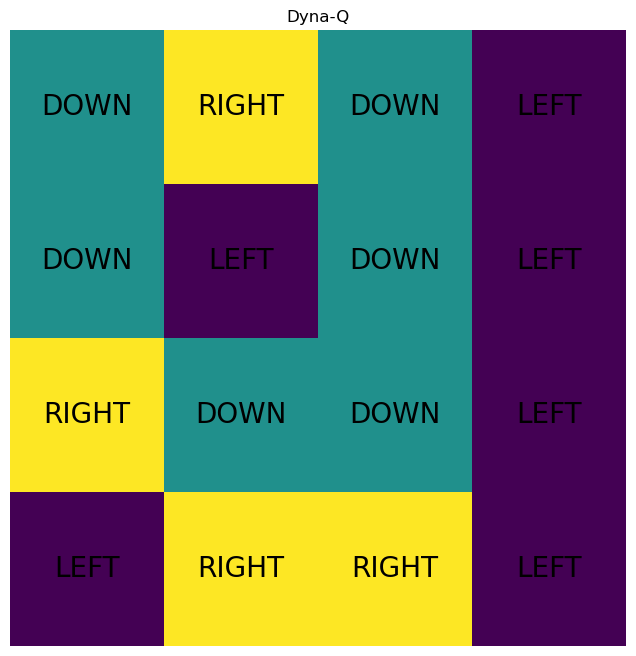

In [88]:
# display
display_policy(agent.q, id_to_action, figsize=(8,8), title="Dyna-Q", map_size=4)

In [50]:
# render optimal policy

agent.current_state = agent.env.reset()[0]
while True:
    action = agent.choose()
    # do agent observe
    _, is_done, _, _, _, _ = agent.observe(action)
    clear_output(True)
    print(agent.env.render())
    time.sleep(0.5)
    if is_done:
        break

  (Right)
SFFF
FHFH
FFFH
HFFG



> What are some limits of the algorithm ? Does it scale ? Explain. 

_Parts of the code for this practical has been inspired by https://github.com/yandexdataschool/Practical_RL/_